# Quiz 2


In this quiz it was assigned the task of calibration a camera using three different methods. The first using a tool called [camera calibration toolbox](https://github.com/nghiaho12/camera_calibration_toolbox_octave), the second following the naive method presented in the classrom, and the third implementing the algorithm described in the book Introductory Techniques for 3-D Computer Vision (Pg. 130). The three calibrations follow bellow in the same order described above.


## Camera Calibration Toolbox

In this first method the camera calibration toolbox was used to calculate the intrinsic parameters of the camera. First the toolbox was supplied 15 pictures of a chessboard pattern target, from different positions. Then corner positions in the image were computed, length of a single square supplied.

<img src="calibration_images.png" width=500>
<blockquote>Images supplied to the toolbox</blockquote>

After that the application had all information it needed to calculate the intrinsic parameters of the camera, as well as the extrinsic parameters of each picture. The results were as follow:
```
Focal Length:          fc = [ 3022.34810   3024.98266 ] +/- [ 12.75023   12.68773 ]
Principal point:       cc = [ 2022.32166   1518.06956 ] +/- [ 18.42196   14.75389 ]
Skew:             alpha_c = [ 0.00000 ] +/- [ 0.00000  ]   => angle of pixel axes = 90.00000 +/- 0.00000 degrees
Distortion:            kc = [ 0.07608   -0.16286   0.00239   0.00107  0.00000 ] +/- [ 0.01337   0.05607   0.00193   0.00236  0.00000 ]
Pixel error:          err = [ 0.97779   0.96366 ]
```
#### Extrinsic Parameters:
<table>
    <tr>
        <td>World Centered</td>
        <td>Camera Centered</td>
    </tr>
    <tr>
    <td><img src="extrinsic_world.png" width=400></td>
    <td><img src="extrinsic_camera.png" width=400></td>
    </tr>
</table>


## Naive Method

In this method the intrinsic parameters of the camera were calculated using a simple naive algorithm. First a picture of a book with a known size was taken from a known distance. Then the size of the book in pixels in the image was measured, and that is enough information to calculate the focal lengths. To create the intrinsic parameters matrix we assumed that the optical center was at the center of the image and that the pixels were square.

<img src="./livro.jpg" width=600>

In [14]:
d_X = 18.5
d_x = 1250
d_Y = 24
d_y = 1644
d_Z = 45

f_x = (d_x/d_X)*d_Z
f_y = (d_y/d_Y)*d_Z

M_int = [[f_x, 0  , 2000],         
        [0  , f_y, 1500 ],
        [0  ,   0,  1   ]]
print(M_int)

[[3040.5405405405404, 0, 2000], [0, 3082.5, 1500], [0, 0, 1]]


As we can see this algorithm provided very similar results for the focal lengths to the ones computed by the toolbox, differing by only about 1%. This adds credibility to both the naive algorithm's result, and the toolbox results. In the following algorithm we will be expecting a value of about ~3000 for the focal length.

## EXPL_PARS_CAL implementation

What follows is the implementation of the EXPL_PARS_CAL algorithm descibed in the book Introductory Techniques for 3-D Computer Vision (Pg. 130). The algorithm is supplied with a list of point coordinates of the image with a list of coordinates of said points in the world. The point coordinates were extracted from a photo of a target consisting of two chessboard patterns, in different planes.

<img src="alvo.jpg" width=500>

In [1]:
# Steps 1 and 2
import cv2
import numpy as np
from matplotlib import pyplot as plt
from math import sqrt

# Detect all corners on the target
img = cv2.imread('alvo_limpo.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,8,3,0.04)
ret, dst = cv2.threshold(dst,0.09*dst.max(),255,0)
dst = np.uint8(dst)
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
len(corners)

165

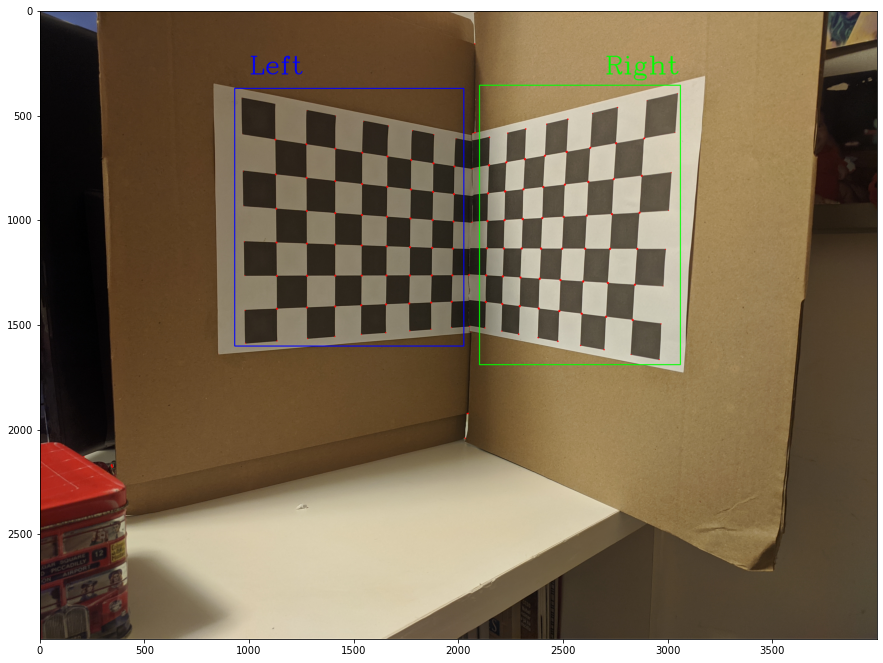

In [16]:
# Draw and display image showing the detected corners. 
# Also show what areas of the image from which we are going to collect the points (Left, Right).
l = np.array([[930, 369], [2025, 369],  [2025,1600], [930, 1600]])
l = l.reshape((-1,1,2))
cv2.polylines(img, [l], True, (255,0,0), 4)
cv2.putText(img, "Left", (1000, 300), cv2.FONT_HERSHEY_COMPLEX, 4, (255, 0, 0), 3, cv2.LINE_AA)

r = np.array([[2100, 354], [3060, 354], [3060, 1689], [2100,1689]])
r = r.reshape((-1,1,2))
cv2.putText(img, "Right", (2700, 300), cv2.FONT_HERSHEY_COMPLEX, 4, (0, 255, 0), 3, cv2.LINE_AA)

cv2.polylines(img, [r], True, (0,255,0), 4)

img[dst>0.05*dst.max()]=[0,0,255]

plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [17]:
# Divide the pattern in two delimited areas so we can properly select the detected corners we are interested in
left = [(point[0], point[1]) for point in corners[1:] if 930 < point[0] < 2025 and 369 < point[1] < 1600]
right = [(point[0], point[1])  for point in corners[1:] if 2100 < point[0] < 3060 and 354 < point[1] < 1689]

In [18]:
# The goal of this step is to agrupate the points acording to their column on the pattern. 
# This is tailored to work with the image used, and may not work with different images

left = sorted(left, key=lambda x: x[0])
columns_left = [left[i:i+8] for i in range(0, len(left), 8)]

right = sorted(right, key=lambda x: x[0])
columns_right = [right[i:i+8] for i in range(0, len(right), 8)]

In [19]:
# Now we assign to each point the corresponding world coordinate
coords = []

for i, col in enumerate(columns_left):
    col = sorted(col, key=lambda x: x[1])
    world = [(0, (9-i)*28, row*28) for row in reversed(range(0, 7))]
    coords = coords + [(ic, wc) for ic, wc in zip(col, world)]

for i, col in enumerate(columns_right):
    col = sorted(col, key=lambda x: x[1])
    world = [((i+1)*28, 0, row*28) for row in reversed(range(0, 7))]
    coords = coords + [(ic, wc) for ic, wc in zip(col, world)]


In [20]:
# Finally we construct A as described in the book
A = np.array([[ic[0]*wc[0], ic[0]*wc[1], ic[0]*wc[2], ic[0], -ic[1]*wc[0], -ic[1]*wc[1], -ic[1]*wc[2], -ic[1]] for ic, wc in coords])


In [21]:
# Step 3
U, S, Vt = np.linalg.svd(A, full_matrices=False) # 3
col, _= min(enumerate(S), key=lambda x: x[1])



In [22]:
# Step 4
sol = Vt[col,:]
g = sqrt(sol[0]**2 + sol[1]**2 + sol[2]**2)
a = sqrt(sol[4]**2 + sol[5]**2 + sol[6]**2)/g
print(g)
print(a)


0.002013965490353308
1.0471019349939648


In [23]:
# Step 5
R_2 = np.array([sol[0]/g, sol[1]/g, sol[2]/g])
R_1 = np.array([sol[4]/(g*a), sol[5]/(g*a), sol[6]/(g*a)])
T_y = sol[3]/g
T_x = sol[7]/(g*a)


In [24]:
# Step 6 and 7
R_3 = np.cross(R_2, R_1)
if 2310*(R_1[0]*3*28 + R_1[2]*5*28 + T_x) > 0:
    R_1 = -R_1
    R_2 = -R_2
    T_x = -T_x
    T_y = -T_y


In [25]:
# Step 8
A = np.array([[ic[0], (R_1[0]*wc[0] + R_1[1]*wc[1] + R_1[2]*wc[2] + T_x)] for ic, wc in coords])
b = np.array([-ic[0]* (R_3[0]*wc[0] + R_3[1]*wc[1] + R_3[2]*wc[2]) for ic, wc in coords])

x, res, rank, s = np.linalg.lstsq(A,b, rcond=None) # x = np.linalg.inv(np.transpose(A).dot(A)).dot(np.transpose(A)).dot(b)
T_z, f_x = x

results = f"""
f_x: {f_x}
f_y: {f_x/a}
T: [{T_x}, {T_y}, {T_z}]
R: ┏                                {"┓":>38}
   ┃ {R_1[0]},  {R_1[1]},    {R_1[2]} ┃
   ┃  {R_2[0]},    {R_2[1]},   {R_2[2]}   ┃
   ┃ {R_3[0]},   {R_3[1]},  {R_3[2]}  ┃
   ┗                                {"┛":>38}
"""
print(results)



f_x: 4064.580526583893
f_y: 3881.7429237272113
T: [-393.5979368417609, -276.92187130845065, 717.705116107148]
R: ┏                                                                     ┓
   ┃ -0.010787793986246694,  0.9983228294868526,    0.056878393316574724 ┃
   ┃  0.2720660479883072,    0.23983640815020094,   0.9319112419418677   ┃
   ┃ -0.9167067583316105,   -0.025527946177101198,  0.27419705259651844  ┃
   ┗                                                                     ┛



As we can see, the obtained values greatly differed from the ones obtained in the previous two calibrations. Why that is could not be determined by the author. In its initial implementation instead of detecting the corners on the target, 7 points were manually listed, and the focal length obtained was close to 0. Then, trying to see if the result would converge, about 70 points were manually listed. The focal length had then surpassed what was expected, resulting in a value of 3500. At this point the automatic corner detection was implemented, and the result diverged even more.

The reason for this much divergence could not be determined, but it can be conjectured that this implementation does not follow at least one of the steps correctly. Extensive attempts to rectify this issue were made, however it could not be determined where the error lies.

